### 6. Aplicación tensores orden 3 o superior

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 31s 0us/step


In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


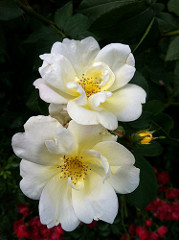

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

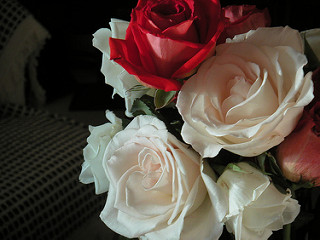

In [9]:
PIL.Image.open(str(roses[1]))

In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


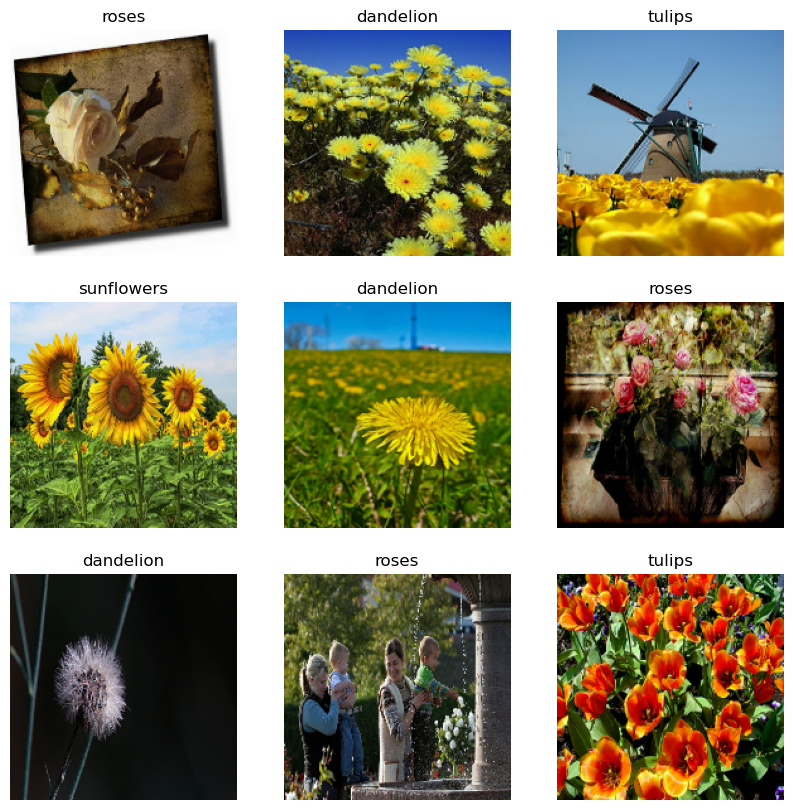

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
normalization_layer = layers.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9891067


In [19]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


92/92 [==============================] - 33s 328ms/step - loss: 1.3317 - accuracy: 0.4418 - val_loss: 1.1127 - val_accuracy: 0.5136
Epoch 2/10
92/92 [==============================] - 25s 277ms/step - loss: 1.0001 - accuracy: 0.6124 - val_loss: 0.9599 - val_accuracy: 0.6253
Epoch 3/10
92/92 [==============================] - 25s 273ms/step - loss: 0.8057 - accuracy: 0.7033 - val_loss: 0.9177 - val_accuracy: 0.6322
Epoch 4/10
92/92 [==============================] - 25s 274ms/step - loss: 0.5992 - accuracy: 0.7830 - val_loss: 0.9825 - val_accuracy: 0.6512
Epoch 5/10
92/92 [==============================] - 25s 270ms/step - loss: 0.3678 - accuracy: 0.8804 - val_loss: 1.0352 - val_accuracy: 0.6485
Epoch 6/10
92/92 [==============================] - 25s 270ms/step - loss: 0.2325 - accuracy: 0.9244 - val_loss: 1.2351 - val_accuracy: 0.6294
Epoch 7/10
92/92 [==============================] - 25s 275ms/step - loss: 0.1229 - accuracy: 0.9625 - val_loss: 1.4714 - val_accuracy: 0.61

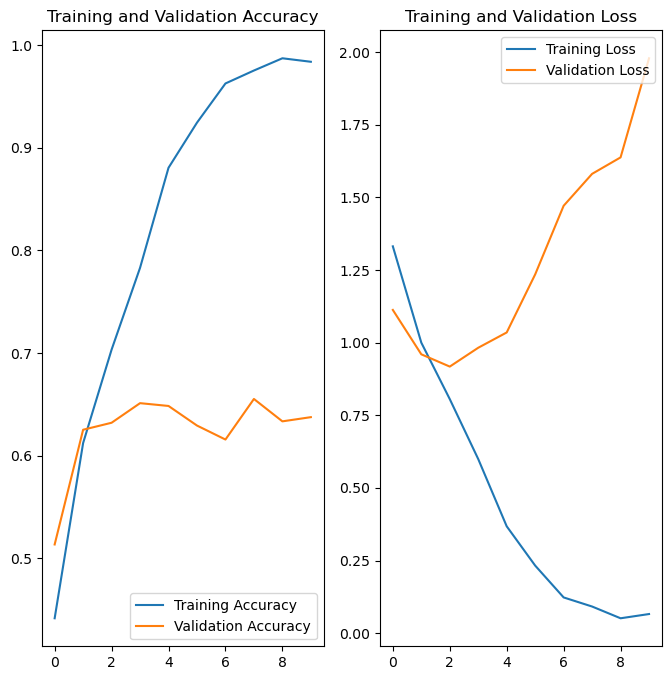

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [25]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

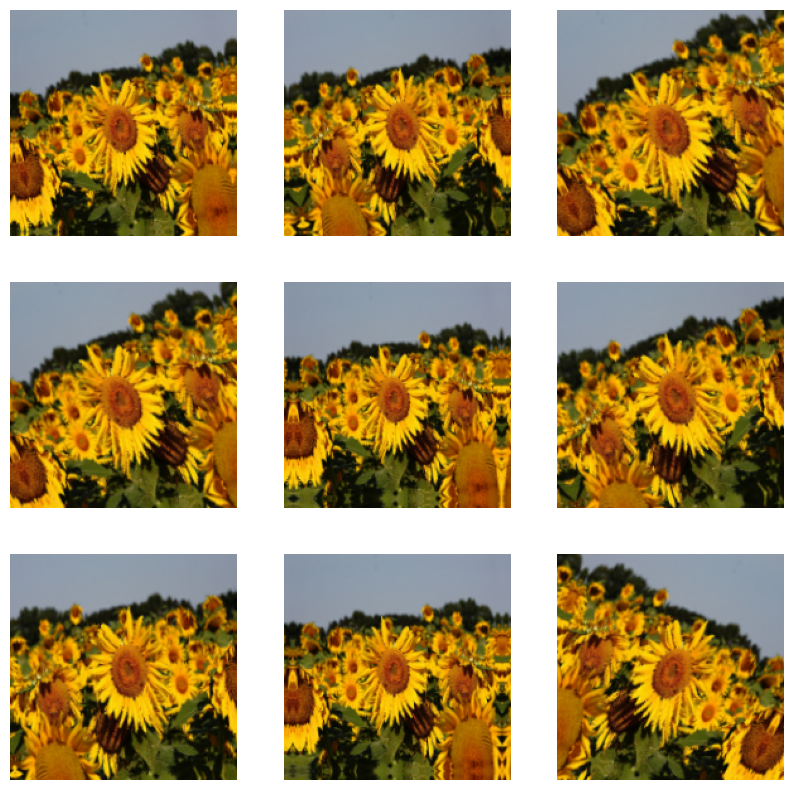

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [27]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [30]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 32s 324ms/step - loss: 1.3129 - accuracy: 0.4312 - val_loss: 1.0718 - val_accuracy: 0.5504
Epoch 2/15
92/92 [==============================] - 28s 308ms/step - loss: 1.0482 - accuracy: 0.5865 - val_loss: 1.2378 - val_accuracy: 0.5504
Epoch 3/15
92/92 [==============================] - 28s 306ms/step - loss: 0.9510 - accuracy: 0.6213 - val_loss: 1.0070 - val_accuracy: 0.6172
Epoch 4/15
92/92 [==============================] - 28s 302ms/step - loss: 0.8847 - accuracy: 0.6642 - val_loss: 0.9558 - val_accuracy: 0.6294
Epoch 5/15
92/92 [==============================] - 30s 321ms/step - loss: 0.8458 - accuracy: 0.6730 - val_loss: 0.8262 - val_accuracy: 0.6812
Epoch 6/15
92/92 [==============================] - 30s 330ms/step - loss: 0.7969 - accuracy: 0.6986 - val_loss: 0.7874 - val_accuracy: 0.7016
Epoch 7/15
92/92 [==============================] - 32s 350ms/step - loss: 0.7492 - accuracy: 0.7170 - val_loss: 0.7900 - val_accuracy: 0.7016

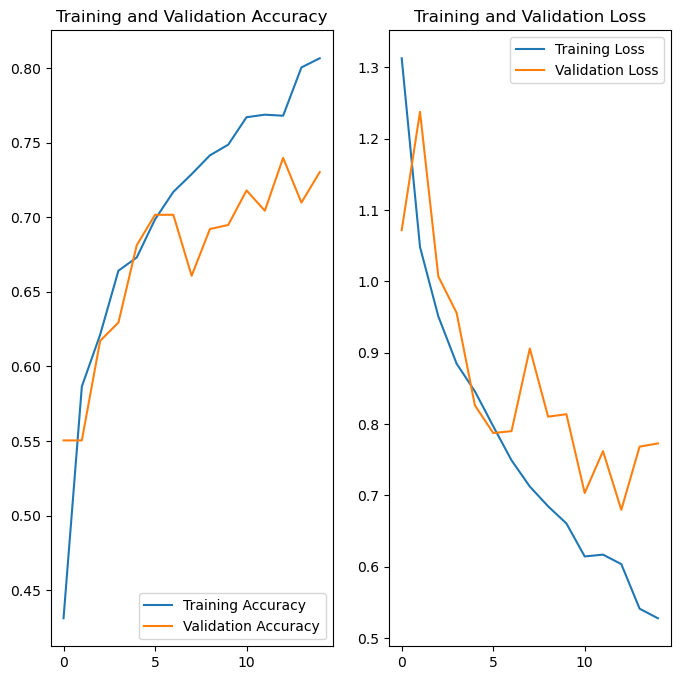

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 20ms/step
This image most likely belongs to sunflowers with a 99.50 percent confidence.


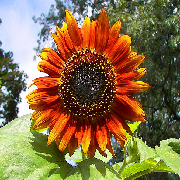

In [41]:
img

In [47]:
tulipan_url = "https://s1.eestatic.com/2020/06/23/curiosidades/naturaleza-planeta-tierra/ciencias_naturales-flores-naturaleza_y_planeta_tierra_499960581_154305912_1706x960.jpg"
tulipan_path = tf.keras.utils.get_file('ciencias_naturales-flores-naturaleza_y_planeta_tierra_499960581_154305912_1706x960', origin=tulipan_url)

img2 = tf.keras.utils.load_img(
    tulipan_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img2)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 52ms/step
This image most likely belongs to tulips with a 99.21 percent confidence.


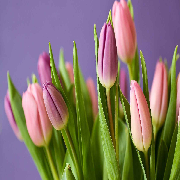

In [48]:
img2